# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm 
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="white")

In [2]:
hf = pd.read_csv('kc_house_data_train.csv')


In [3]:
hf1 = hf.copy()

In [60]:
hf.keys()

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'condition', 'sqft_above', 'sqft_basement',
       ...
       'average', 'above_avg', 'good', 'high_qua', 'higher_qua',
       'excellent_qua', 'mansion', 'No_Waterfront', 'Waterfront',
       'water_sqft_lot'],
      dtype='object', length=104)

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 540739.55 and sigma = 373308.18



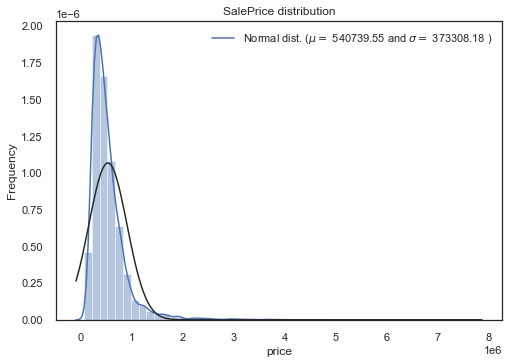

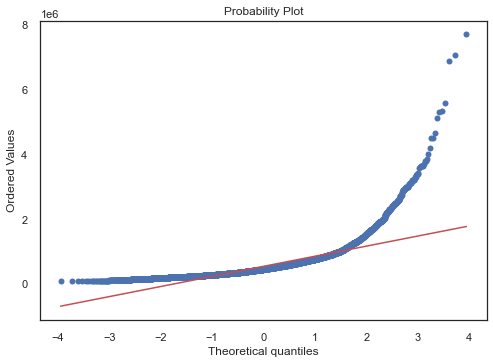

Skewness: 4.282599
Kurtosis: 38.520298


In [59]:
# Plot Histogram
sns.distplot(hf['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(hf['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(hf['price'], plot=plt)
plt.show()

print("Skewness: %f" % hf['price'].skew())
print("Kurtosis: %f" % hf['price'].kurt())


/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='bathrooms'>

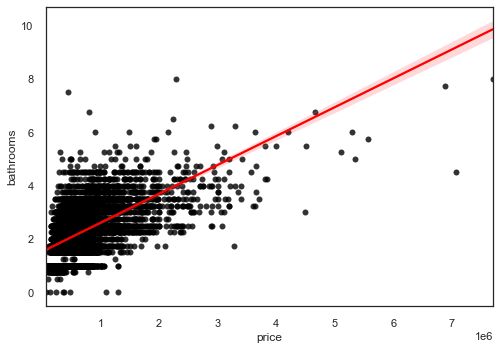

In [5]:
sns.regplot(hf['price'],hf['bathrooms'], scatter_kws={"color": "black"}, line_kws={"color": "red"})

<function matplotlib.pyplot.show(close=None, block=None)>

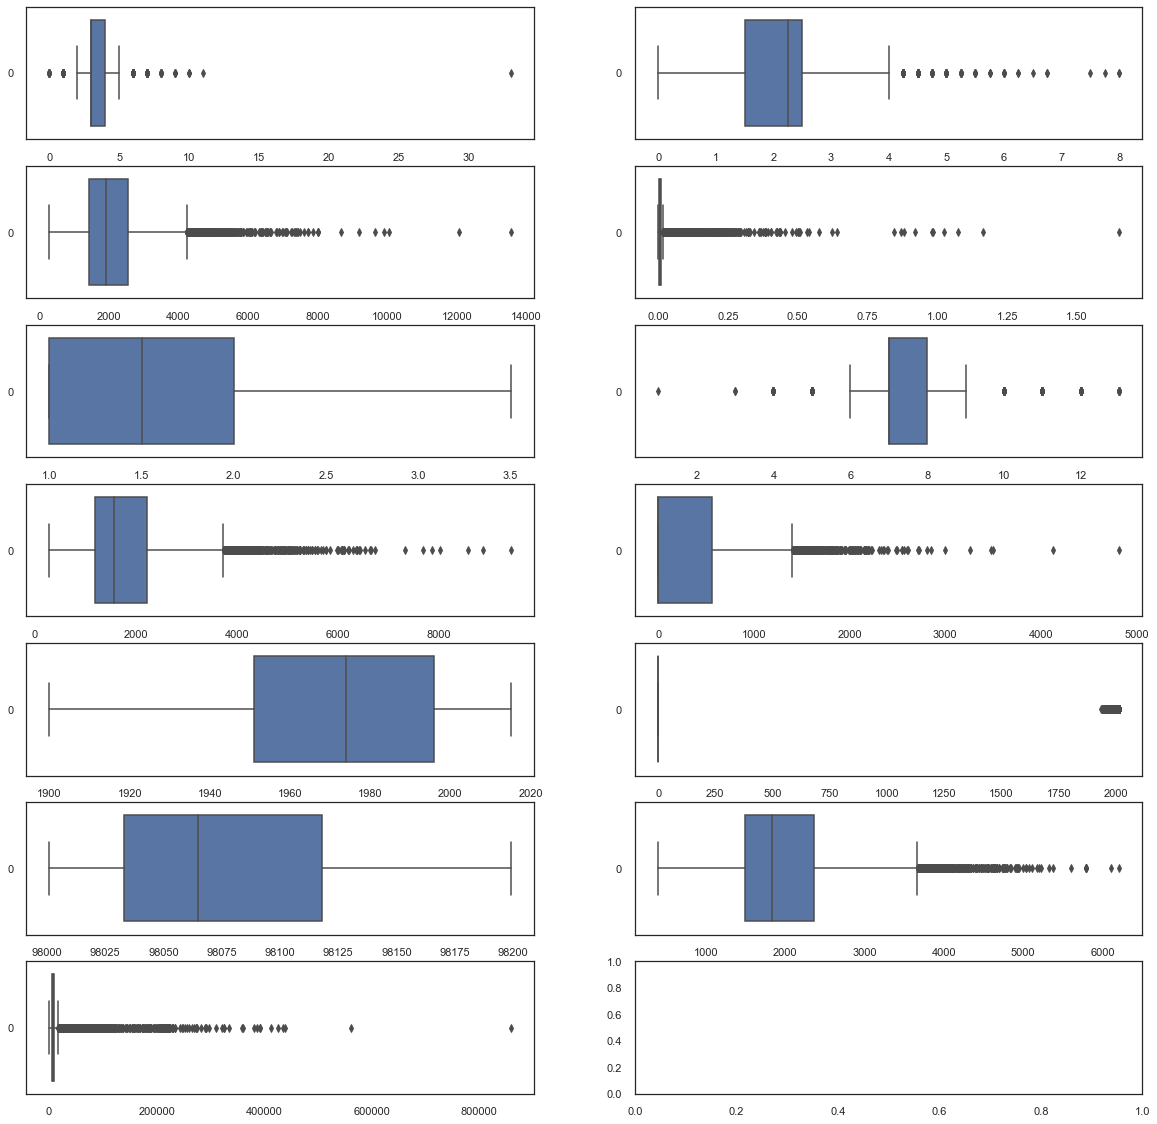

In [6]:
fig, axes = plt.subplots(7,2, figsize = (20, 20))


sns.boxplot(ax = axes[0,0], data = hf['bedrooms'], orient = 'h')
sns.boxplot(ax = axes[0,1], data = hf['bathrooms'], orient = 'h')
sns.boxplot(ax = axes[1,0], data = hf['sqft_living'], orient = 'h')
sns.boxplot(ax = axes[1,1], data = hf['sqft_lot'], orient = 'h')
sns.boxplot(ax = axes[2,0], data = hf['floors'], orient = 'h')
sns.boxplot(ax = axes[2,1], data = hf['grade'], orient = 'h')
sns.boxplot(ax = axes[3,0], data = hf['sqft_above'], orient = 'h')
sns.boxplot(ax = axes[3,1], data = hf['sqft_basement'], orient = 'h')
sns.boxplot(ax = axes[4,0], data = hf['yr_built'], orient = 'h')
sns.boxplot(ax = axes[4,1], data = hf['yr_renovated'], orient = 'h')
sns.boxplot(ax = axes[5,0], data = hf['zipcode'], orient = 'h')
sns.boxplot(ax = axes[5,1], data = hf['sqft_living15'], orient = 'h')
sns.boxplot(ax = axes[6,0], data = hf['sqft_lot15'], orient = 'h')


plt.show

In [7]:
numerical = ['price', 'sqft_living', 'sqft_lot', 'view',
             'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

categorical = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'zipcode']

hf1 = hf1[numerical + categorical]

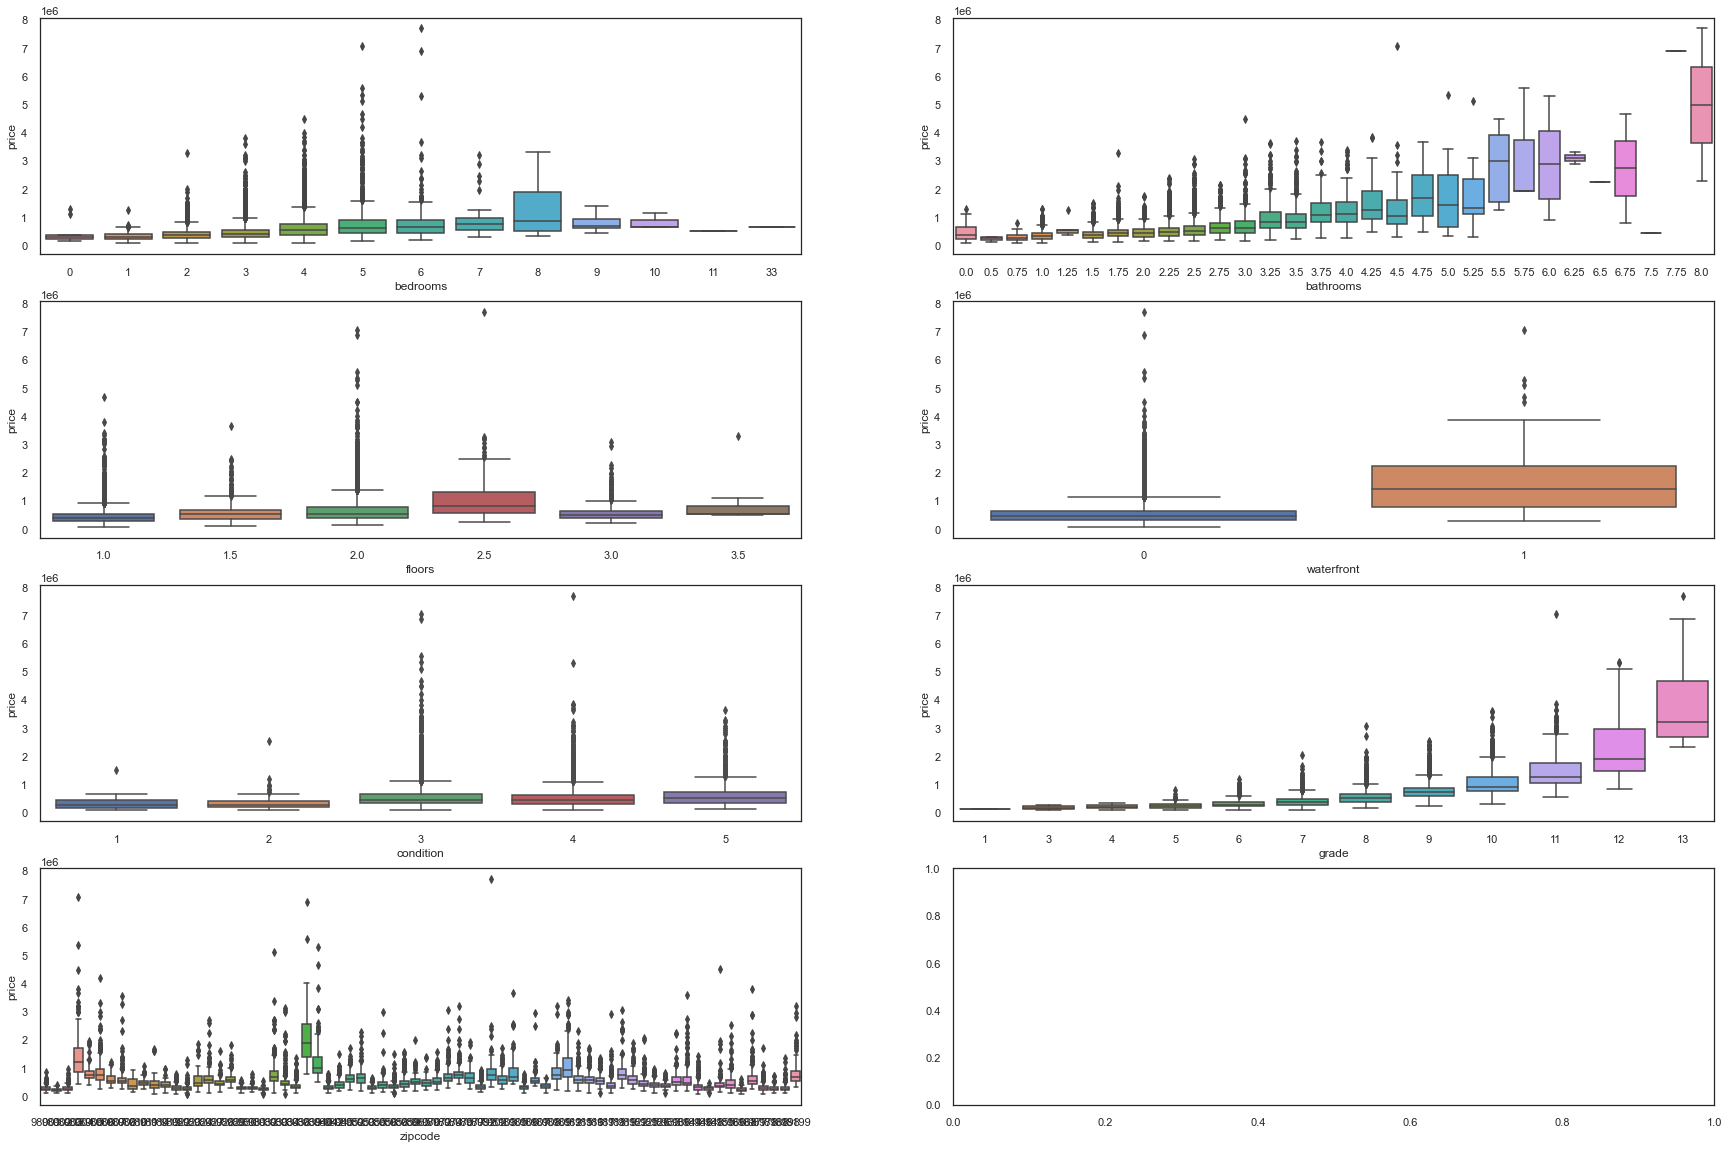

In [62]:
fig, ax = plt.subplots(4, 2, figsize=(30, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='price', data=hf1, ax=subplot)

plt.savefig('boxlpltfeat.png')

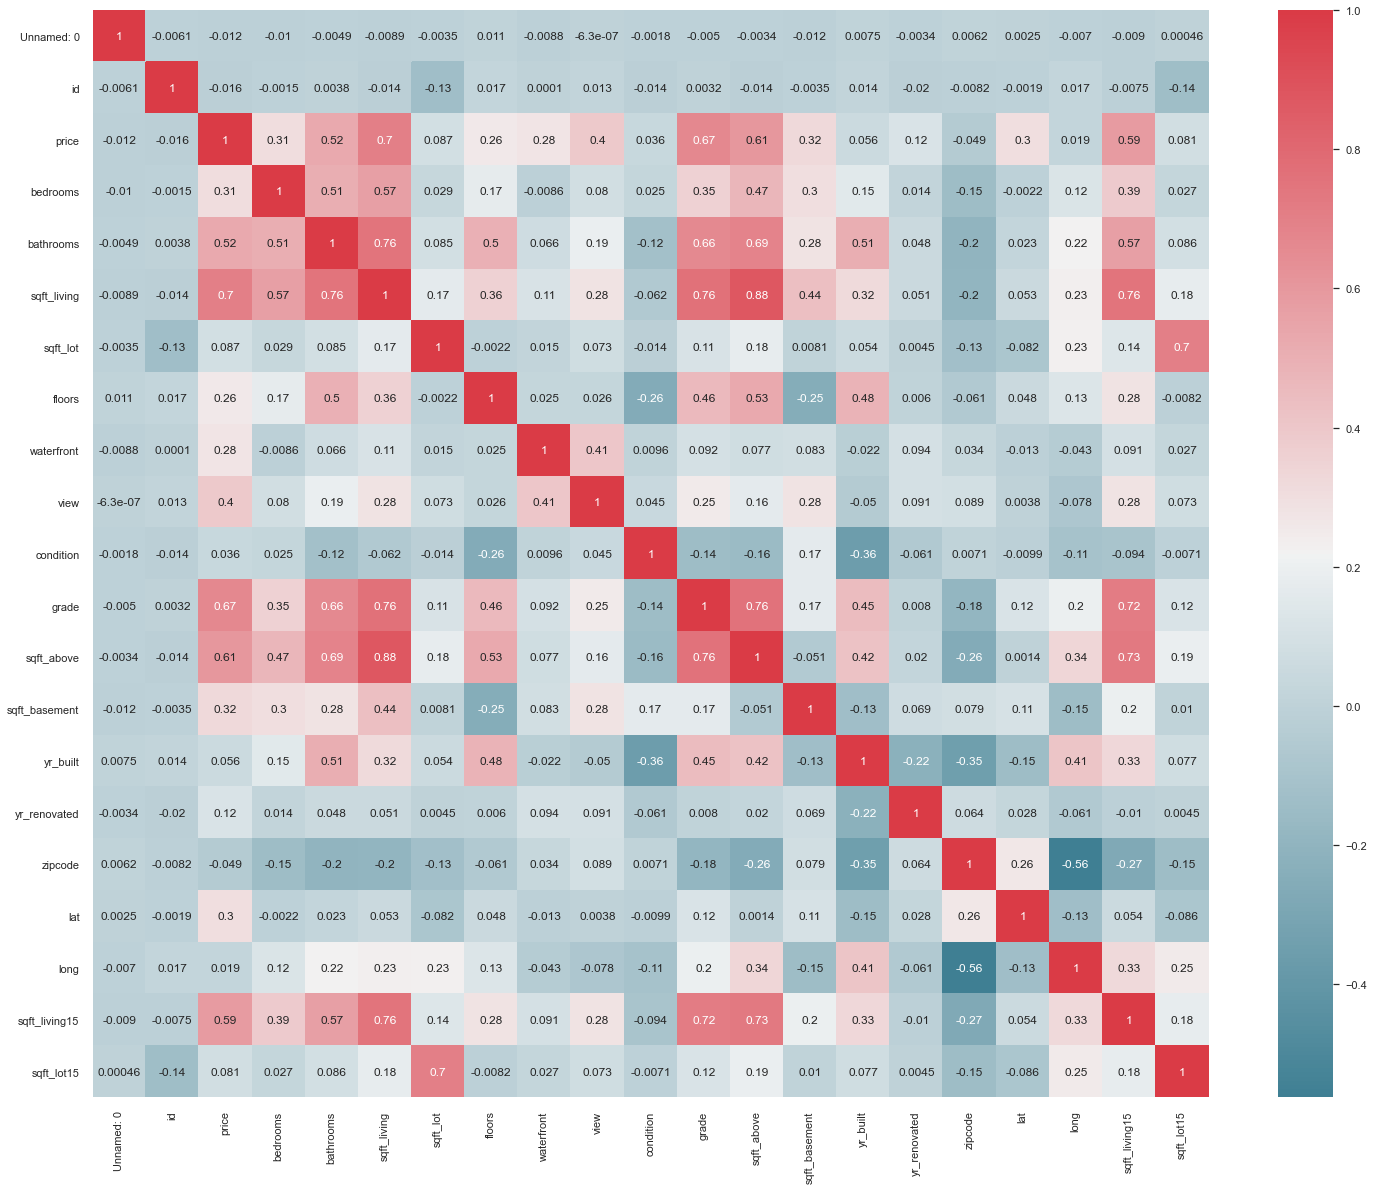

In [9]:
def correlation_heatmap(hf):
    _,ax=plt.subplots(figsize=(25,20))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(hf.corr(),annot=True,cmap=colormap)
    
correlation_heatmap(hf)

## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [10]:
def zero_val_bed_bath(row):
    """
    Checking extreame number of rooms in the house
    """
    if row['bedrooms'] == 0:
        row['bedrooms'] = row['floors']
    if row['bathrooms'] < 1:
        row['bathrooms'] = 1
    if row['bedrooms'] > 10 :
        row['bedrooms'] = 10
    return row

In [11]:
hf = hf.apply(zero_val_bed_bath, axis = 1)

In [12]:
hf.drop(columns = ['Unnamed: 0', 'id', 'view', 'sqft_living15', 'sqft_lot15'], inplace = True)

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [13]:
hf['yr_updated'] = np.nan

In [14]:
def yr_update(row):
    
    if row['yr_renovated'] == 0:
        row['yr_updated'] = 2021 - row['yr_built']
    if row['yr_renovated'] != 0:
        row['yr_updated'] = 2021 - row['yr_built']
        
    return row 
    

In [18]:
hf = hf.apply(yr_update, axis = 1)

In [15]:
hf['yr_ren'] = np.nan

In [16]:
def yr_ren(row):
    
    if row['yr_renovated'] == 0:
        row['yr_ren'] = 0
    if row['yr_renovated'] != 0:
        row['yr_ren'] = 2021 - row['yr_built']
        
    return row 

In [19]:
hf = hf.apply(yr_ren, axis = 1)

In [20]:
hf['percent_bedbath'] = np.nan
hf['has_golden_ratio'] = np.nan

In [21]:
def cal_ratio_range(row):
    golden_ratio = (2/3)
    golden_ratio_plus = golden_ratio + (golden_ratio * .10)
    golden_ratio_minus = golden_ratio - (golden_ratio * .10)
    
    if row['percent_bedbath'] <= golden_ratio_plus and row['percent_bedbath'] >= golden_ratio_minus:
            row['has_golden_ratio'] = 1
    else:
        row['has_golden_ratio'] = 0
    
    return row

In [22]:
hf = hf.apply(cal_ratio_range, axis = 1)

In [23]:
# Based off of bathrooms pros and housetipster 

def ratio_bed_bath(row):
    
    ratio_bed_bath = row['bathrooms'] / row['bedrooms']
    golden_ratio = (2/3)
    row['percent_bedbath'] = abs(golden_ratio - ratio_bed_bath) 
    
    return row

In [24]:
hf = hf.apply(ratio_bed_bath, axis = 1)

In [25]:
hf['ratio_liv_lot'] = np.nan

In [26]:
def ratio_living_lot(row):
    
    row['ratio_liv_lot'] = row['sqft_lot'] / row['sqft_living']
    return row
    

In [27]:
hf = hf.apply(ratio_living_lot, axis = 1)

## Step 5: Train-Test Split

If you plan on doing any scaling of your data, make sure it is done at the appropriate time. 

In [28]:
hf = pd.concat([hf, pd.get_dummies(hf['zipcode'])], 1)

In [29]:
hf = hf.drop(columns = 'zipcode')

In [30]:
hf = pd.concat([hf, pd.get_dummies(hf['grade'])], 1)

In [31]:
hf = hf.drop(columns = 'grade')

In [32]:
hf.columns = hf.columns.astype(str)

In [33]:
# lowest g: 1
# low g: 3 Falls short of minimum building standards. Normally cabin or inferior structure.

# dnmc: 4 Generally older, low quality construction. Does not meet code.

# poor: 5 Low construction costs and workmanship. Small, simple design.

# bare_min: 6 Lowest grade currently meeting building code. Low quality materials and simple designs.

# average: 7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

# above_avg: 8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

# good: 9 Better architectural design with extra interior and exterior design and quality.

# high_qua: 10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

# higher_qua: 11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

# excellent qua: 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

# mansion: 13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [34]:
hf = hf.rename(columns={'1': 'lowest_g', '3': 'low_g', '4':'dnmc', '5':'Poor', '6':'bare_min', 
                   '7':'average', '8':'above_avg', '9':'good', '10':'high_qua', '11':'higher_qua',
                   '12':'excellent_qua', '13':'mansion' })

In [35]:
# waterfront times sqft_lot
hf = pd.concat([hf, pd.get_dummies(hf['waterfront'])], 1)

In [36]:
hf = hf.rename(columns={0: "No_Waterfront", 1: "Waterfront"})

In [37]:
hf['water_sqft_lot'] = np.nan

In [38]:
def water_lot(row):
    if row['waterfront'] == 1:
        row['water_sqft_lot'] = row['Waterfront'] * row['sqft_lot'] 
    if row['waterfront'] == 0:
        row['water_sqft_lot'] = 0
    return row

In [39]:
hf = hf.apply(water_lot, axis=1)

In [40]:
hf = hf.drop(columns='waterfront')

In [41]:
features = ['bedrooms', 'bathrooms', 
            'sqft_living', 'sqft_lot', 'floors', 'condition', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 
            'percent_bedbath','has_golden_ratio', 'lowest_g','low_g', 'dnmc', 'Poor', 
            'bare_min', 'average', 'above_avg', 'good', 'high_qua', 'higher_qua', 
            'excellent_qua', 'mansion', 'No_Waterfront',  'Waterfront', 'water_sqft_lot',
            '98001', '98002', '98003', '98004', '98005', '98006',
           '98007', '98008', '98010', '98011', '98014', '98019', '98022', '98023',
           '98024', '98027', '98028', '98029', '98030', '98031', '98032', '98033',
           '98034', '98038', '98039', '98040', '98042', '98045', '98052', '98053',
           '98055', '98056', '98058', '98059', '98065', '98070', '98072', '98074',
           '98075', '98077', '98092', '98102', '98103', '98105', '98106', '98107',
           '98108', '98109', '98112', '98115', '98116', '98117',
           '98118', '98119', '98122', '98125', '98126', '98133', '98136', '98144',
           '98146', '98148', '98155', '98166', '98168', '98177', '98178', '98188',
           '98198', '98199']

hf_features = hf[features]
target = hf['price']

In [42]:
def model_test(df, features, target):
    df_features = df[features]
    X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.2)
    #instantiate a linear regression object
    lm = linear_model.LinearRegression()

    #fit the linear regression to the data
    lm = lm.fit(X_train, y_train)
    
    y_train_pred = lm.predict(X_train)
    
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
    train_mse = metrics.mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
   
    # Test Set
    y_pred = lm.predict(X_test)
    
    #test_mae = metrics.mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    #print('Mean Absolute Error:' + str(metrics.mean_absolute_error(y_test, y_pred)))
    #print('Mean Squared Error:' + str(metrics.mean_squared_error(y_test, y_pred)))
    print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

In [43]:
model_test(hf, features, target)

Training:  154906 vs. Testing:  209560726


In [44]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_basement', 'yr_ren', 'yr_updated']

poly_ft = hf[features]
target = hf['price']

In [45]:
def poly_df (df, degree):
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_data = poly.fit_transform(df)
    poly_columns = poly.get_feature_names(df.columns)
    df_poly = pd.DataFrame(poly_data, columns=poly_columns)
    return df_poly

In [46]:
poly_df = poly_df(poly_ft, 2)

In [47]:
final_df = pd.concat([hf_features, poly_df], 1)

In [48]:
final_df.shape

(17290, 124)

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

In [49]:
effect_feat = ['yr_built', 'percent_bedbath', 'lowest_g', 'dnmc', 'Poor', 'bare_min',
               'average', 'above_avg','good', 'high_qua', 'higher_qua', 'excellent_qua',
               'mansion',
               '98001', '98002', '98003', '98004', '98005', '98006', '98007', '98008',
               '98010', '98011', '98014', '98019', '98022', '98023', '98024', '98027',
               '98028', '98029', '98030', '98031', '98032', '98033', '98034', '98038', 
               '98039', '98040', '98042', '98045', '98052', '98053', '98055', '98056',
               '98058', '98059', '98065', '98070', '98072', '98074', '98075', '98077',
               '98092', '98102', '98103', '98105', '98106', '98107', '98108', '98109',
               '98112', '98115', '98116', '98117', '98118', '98119', '98122', '98125',
               '98133', '98136', '98144', '98146', '98148', '98155', '98166', '98168',
               '98177', '98178', '98188', '98198', '98199', 'No_Waterfront', 'Waterfront',
               'bathrooms', 'sqft_living', 'yr_updated']

In [50]:
final_df = final_df[effect_feat]

## Step 7: Evaluate your different models in order to determine the best model overall.

In [52]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

alpha = 0.05 
#ANOVA Test Setup
formula = 'price~C(floors)'
lm_condition = smf.ols(formula, hf).fit()
anova_condition = sm.stats.anova_lm(lm_condition, type=2)
if anova_condition["PR(>F)"][0] < alpha:
    print("The number of floors has a statistically significant impact on average property value")
    print("Conditions F-statisic Probability: ", anova_condition["PR(>F)"][0])

The number of floors has a statistically significant impact on average property value
Conditions F-statisic Probability:  0.0


In [53]:
is_waterfront = hf[(hf['Waterfront'] == 1)]
waterfront_price = is_waterfront.price
no_waterfront = hf[(hf['Waterfront'] == 0)]
notwaterfront_price = no_waterfront.price
alpha = 0.05
waterfront_p_val = stats.ttest_ind(waterfront_price, notwaterfront_price, equal_var=False)[1]
print("Waterfront vs No Waterfront T-test P Value: ", waterfront_p_val)
if waterfront_p_val < alpha:
    print("The P value is less than alpha, reject null-hypothesis")

Waterfront vs No Waterfront T-test P Value:  6.940441256090536e-23
The P value is less than alpha, reject null-hypothesis


In [54]:
alpha = 0.05 
#ANOVA Test Setup
formula = 'price~C(bedrooms)'
lm_condition = smf.ols(formula, hf).fit()
anova_condition = sm.stats.anova_lm(lm_condition, type=2)
if anova_condition["PR(>F)"][0] < alpha:
    print("The number of bedrooms has a statistically significant impact on average property value")
    print("Conditions F-statisic Probability: ", anova_condition["PR(>F)"][0])

The number of bedrooms has a statistically significant impact on average property value
Conditions F-statisic Probability:  0.0


## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [55]:
import pickle

In [ ]:
def scale_fit_pickle_origin(df_features, target):
    """
    Scaling df with features,
    Fit linear model with scaled features
    Create pickle file with Scaler and Model
    params: 
            df_features - most important features 
            target - Series
    """
#     scaler = StandardScaler()
#     # fit the scaler to the training data
#     scaler.fit(df_features)
#     #transform the training data
#     scaled_data = scaler.transform(df_features)
#     #create dataframe
#     df_features_scaled = pd.DataFrame(data=scaled_data, columns=df_features.columns, index=df_features.index)
    lm_final = LinearRegression()
#     #fit the linear regression to the data
    lm_final = lm_final.fit(df_features, target)
    pickle_out = open("model.pickle","wb")
    pickle.dump(lm_final, pickle_out)
    pickle_out.close()
#     pickle_out = open('scaler.pickle', "wb")
#     pickle.dump(scaler, pickle_out)
#     pickle_out.close()
    return print(' CONGATS !!! You sucessfuly created you pickles for SCALER and MODEL')

In [ ]:
scale_fit_pickle_origin(final_df, hf['price'])